In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run /home/jebediah/Ising_RSRG/aux_funcs.py
%run /home/jebediah/Ising_RSRG/RSRG_class.py
%run /home/jebediah/Ising_RSRG/aux_funcs.py

In [16]:
log_file = pd.read_csv("log_file.csv")[48:60]
ts_list = log_file['ts'].tolist()
log_file

,L,steps,a,b,w,n_runs,ts
48,60,3564,0.1,0.105,1.4,60,1677935698
49,60,3564,0.1,0.105,1.6,60,1677936456
50,60,3564,0.1,0.105,1.8,60,1677937208
51,60,3564,0.1,0.105,2.0,60,1677937968
52,60,3564,0.1,0.105,2.2,60,1677938727
53,60,3564,0.1,0.105,2.4,60,1677939509
54,60,3564,0.1,0.105,2.6,60,1677940327
55,60,3564,0.1,0.105,2.8,60,1677941229
56,60,3564,0.1,0.105,3.0,60,1677942191
57,60,3564,0.1,0.105,3.2,60,1677943221


In [5]:
def generate_corr_matrix(reverse_dict, L):
    vect = np.zeros(shape=(L*L, L*L), dtype=bool)
    for key in reverse_dict:
        if reverse_dict[key] is None: continue
        vect[key,reverse_dict[key]] = True
    return np.einsum('ab,ac->bc', vect, vect)

def generate_corr_matrix_alt(clust_dict, L):
    corr_mat_alt = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        for j in range(i, L*L):
            corr_mat_alt[i,j] = (clust_dict[i]==clust_dict[j])
    corr_mat_alt = corr_mat_alt.T + corr_mat_alt 
    return corr_mat_alt

def generate_corr_matrix_alt2(clust_dict, reverse_dict, L):
    #Fastest
    corr_mat = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        corr_mat[i, reverse_dict[clust_dict[i]]] = True
    return corr_mat

def power_law(x, scale, power):
    return 1/(1+x*scale)**power

In [17]:
L = 60


fixed_length_slice = log_file[lambda df: (df['L'] == L)]
ts_list = fixed_length_slice['ts'].tolist()
w_vals = fixed_length_slice['w'].tolist()
n_runs_list = fixed_length_slice['n_runs'].tolist()

mean_corr_mat_list = []

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)


    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp = core_pair[0]
        reverse_list_temp = core_pair[1]
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    mean_corr_mat = np.zeros(shape=(L*L,L*L))
    for instance in range(len(reverse_dict_list)):
        mean_corr_mat += generate_corr_matrix_alt2(clust_dict_list[instance], reverse_dict_list[instance], L)
    mean_corr_mat = mean_corr_mat/n_runs_list[index]

    mean_corr_mat_list.append(mean_corr_mat)

675848173832120.9 0.018385659768697233
1951942334166.7024 0.031370625116434375
64084.43728487664 0.10371021313329701
57.389290656978865 0.3200954473945691
5.559400001303084 0.78985050215554
3.3861137393856273 1.1967281312005145


(0.0, 20.0)

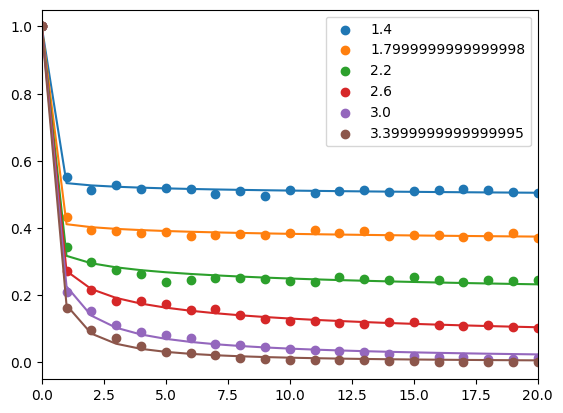

In [20]:
for index, w in enumerate(w_vals):
    if not index%2 == 0: continue
    mean_corr_mat = mean_corr_mat_list[index]
    y_vals = np.arange(L)
    corr_function = np.zeros(shape=(L))

    for y in range(L):
        for x in range(L):
            corr_function[y] += mean_corr_mat[index_map(0,x,L), index_map(y,x,L)]

    plt.scatter(y_vals, corr_function/L, label=str(w))

    popt, pcov = curve_fit(power_law, y_vals[:20],corr_function[:20]/L)

    plt.plot(y_vals, power_law(y_vals, *popt))
    print(*popt)

plt.legend()
plt.xlim(0, 20)


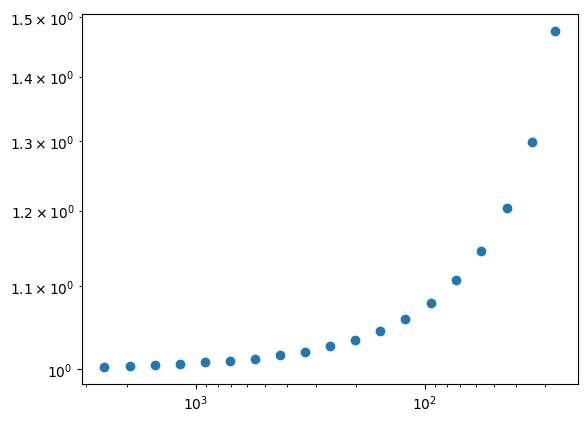

In [29]:
plt.scatter(measure_list[:-1], moment_array.mean(axis=1))

popt, pcov = curve_fit(power_law_scale, x[-5:], width_list[-5:])
plt.plot(x, power_law_scale(x, *popt))

plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')

In [8]:
def process_decimation_type(Omegas, dec_types, poly_degree = 4, convolve_window = 500):
    sorted_dec = np.array([x for _,x in sorted(zip(Omegas,dec_types))])
    sorted_Omegas = np.array(sorted(Omegas))[convolve_window+1:-convolve_window]

    window_size = convolve_window

    mask = np.ones(window_size)/window_size
    convolved_data=np.convolve(sorted_dec,mask,'same')[convolve_window+1:-convolve_window]

    poly = PolynomialFeatures(degree = poly_degree)

    poly_features = poly.fit_transform(sorted_Omegas.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, convolved_data)
    y_predicted = poly_reg_model.predict(poly_features)
    return [-np.log(sorted_Omegas), y_predicted, convolved_data]


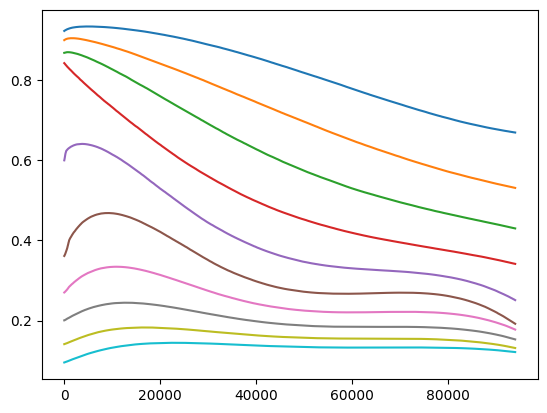

In [57]:


for ts in ts_list:
    with open("Ising_2D_output_"+str(ts)+".pkl", "rb") as fp:   # Unpickling
        output_data = pickle.load(fp)
    Omegas = np.array([])
    dec_types = np.array([])
    h_array, J_array = [], []


    for core, item in enumerate(output_data):
        J_dist_list, h_dist_list, Omega_list_composite, decimation_type_composite = item
        Omegas = np.concatenate((Omegas, Omega_list_composite))
        dec_types = np.concatenate((dec_types, decimation_type_composite))
        if core==0:
            h_array = h_dist_list
            J_array = J_dist_list

        else:
            for i in range(len(input_dict['measure_list'])):
                h_array[i] = np.concatenate((h_array[i], h_dist_list[i]))
                J_array[i] = np.concatenate((J_array[i], J_dist_list[i]))
    dec_type_data = process_decimation_type(Omegas, dec_types, poly_degree=4, convolve_window=500)
    #plt.plot(dec_type_data[0], dec_type_data[2])
    plt.plot(dec_type_data[1])
#plt.gca().invert_xaxis()
#plt.xscale('log')
#plt.ylim(0, 1)

In [23]:
log_file[lambda df: (df['L'] == 50) & (df['a']==0.1)]

,L,steps,a,b,w,n_runs,ts
10,50,2475,0.1,0.105,1.0,60,1677894464
11,50,2475,0.1,0.105,1.5,60,1677895079
12,50,2475,0.1,0.105,2.0,60,1677895609
13,50,2475,0.1,0.105,2.5,60,1677896164
14,50,2475,0.1,0.105,3.0,60,1677896767
15,50,2475,0.1,0.105,3.5,60,1677897442
16,50,2475,0.1,0.105,4.0,60,1677898214
17,50,2475,0.1,0.105,4.5,60,1677899049
18,50,2475,0.1,0.105,5.0,60,1677899960
19,50,2475,0.1,0.105,5.5,60,1677900948


In [9]:
L = 40
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

w_vals = fixed_length_slice['w'].tolist()
largest_clust_size = []
var_lcs = [] 
c_list = []
c_dict = {50:'red', 40:'blue', 60:'green', 80:'cyan', 30:'orange'}

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)
    c_list.append(c_dict[L])

Text(0.5, 1.0, 'Largest Spin Cluster and Variance in Size')

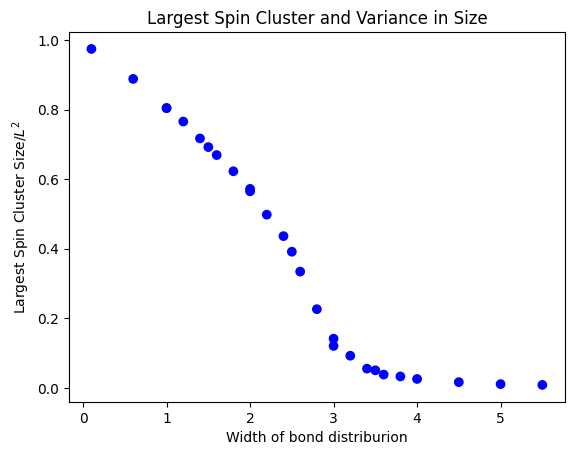

In [10]:
#plt.errorbar(w_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')
plt.scatter(w_vals, largest_clust_size, c=c_list)
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster and Variance in Size")


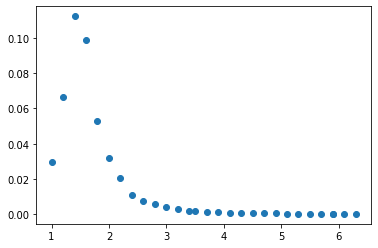

In [41]:
sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
sorted_x = np.array(sorted(w_vals))
plt.scatter(sorted_x, sorted_y)


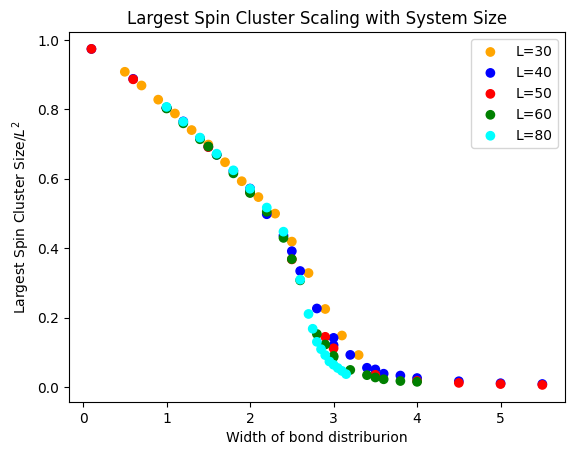

In [20]:
for L in [30, 40, 50, 60, 80]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    largest_clust_size = []
    var_lcs = [] 
    c_list = []
    

    for index, ts in enumerate(ts_list):

        with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        var_lcs.append(largest_clust_list.std()/L**2)
        c_list.append(c_dict[L])

    plt.scatter(w_vals, largest_clust_size, c=c_list, label='L='+str(L))
    
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size")
plt.legend()

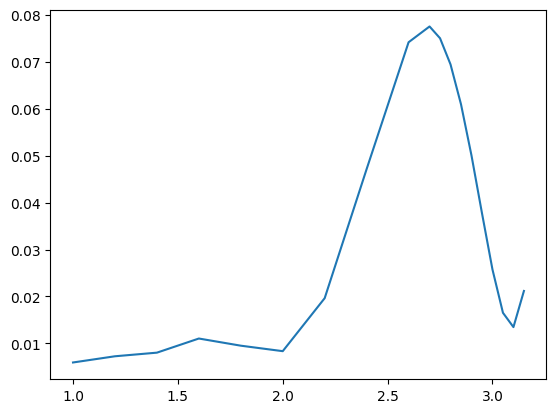

In [21]:
sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
sorted_x = np.array(sorted(w_vals))

poly_degree = 7

poly = PolynomialFeatures(degree = poly_degree)
poly_features = poly.fit_transform(sorted_x.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, sorted_y)
y_predicted = poly_reg_model.predict(poly_features)

plt.plot(sorted_x, y_predicted)

[0.58600978 1.84757256]


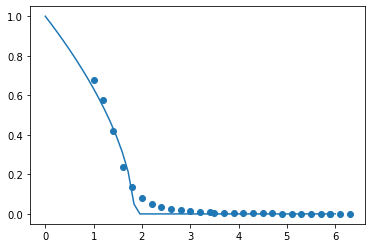

In [37]:
x = np.linspace(0, 6)

def order_param_func(x, scaling, crit_point):
    return np.piecewise(x, [x < crit_point, x >= crit_point], [lambda x: (1-x/crit_point)**scaling, 0])


popt, pcov = curve_fit(order_param_func, w_vals, largest_clust_size)

plt.plot(x, order_param_func(x, *popt))
plt.scatter(w_vals, largest_clust_size)
print(popt)

In [6]:
def check_percolation(clust_dict, L):
    end_point = int(L/2)
    for x1 in range(L):
        for x2 in range(L):
            start_ind = index_map(x1, 0, L)
            end_index = index_map(x2, end_point, L)
            if (clust_dict[start_ind] == clust_dict[end_index]): 
                return True
    return False
        

Text(0.5, 1.0, 'Percolation Transition')

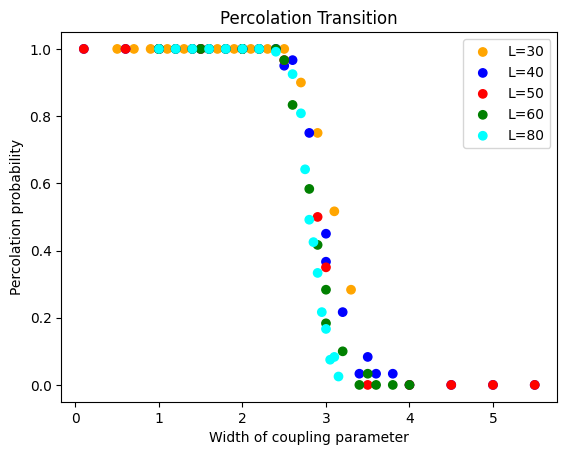

In [26]:
for L in [30, 40, 50, 60, 80]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()

    p_perc_clust = []
    c_list = []
    #color_dict = {50:'blue', 60:'red', 40:'green'}

    for index, ts in enumerate(ts_list):

        with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        perc_cluster = []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        perc_prob_temp = np.array([check_percolation(clust, L) for clust in clust_dict_list])

        p_perc_clust.append(perc_prob_temp.mean())
        c_list.append(c_dict[L])
   
    plt.scatter(w_vals, p_perc_clust, c=c_list, label="L="+str(L))
   

plt.legend()
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")
plt.title("Percolation Transition")

In [109]:
L = 50
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

a_vals = fixed_length_slice['a'].tolist()

largest_clust_size = []
var_lcs = [] 

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)


In [110]:
#a_vals = log_file['a'].tolist()
p_perc_clust = []
c_list = []

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []
    perc_cluster = []

    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    perc_prob_temp = np.array([check_percolation(clust, L) for clust in clust_dict_list])
    
    p_perc_clust.append(perc_prob_temp.mean())
    c_list.append(c_dict[L])

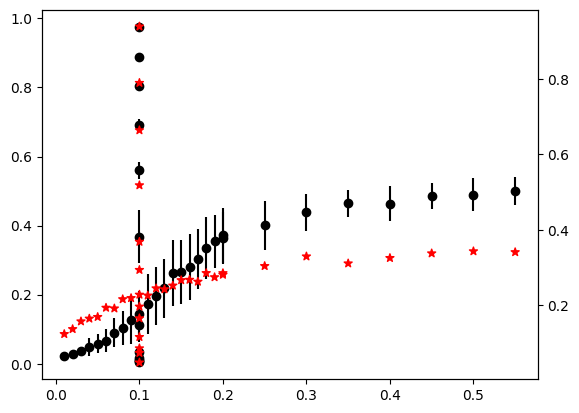

In [112]:
ax1 = plt.subplot()
l1 = ax1.errorbar(a_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='', c='black')
ax2 = ax1.twinx()
l2 = ax2.scatter(a_vals, p_perc_clust, c=c_list, marker='*')
#plt.xscale('log')